
# Music genre identification:
## Visualizing audio features
### John Burt
#### August 2019


The purpose of this notebook is to explore and visualize the features I will be using for my classifier model to estimate whether a music clip is Hip Hop or Folk. In selecting features, I'm trying to capture useful that the classifier can use, while minimizing the number of features passed to the classifier.

[To hide code cells, view this in nbviewer](https://nbviewer.jupyter.org/github/johnmburt/projects/tree/master/music_genre_id/music_genre_id_visualize_features_vf.ipynb) 

#### Methods:

- Mean frequency bin amplitudes of harmonic decomposition of the spectrogram.
- Mean, max and median frequency bin amplitudes of tempogram
- Mean MFCC frequency bin amplitudes 


#### Extra packages required:
- librosa



####  Source data:
- The original data is from ["FMA: A Dataset For Music Analysis"](https://github.com/mdeff/fma). That dataset is a dump of sound clips and associated metadata from the Free Music Archive (FMA), an interactive library of high-quality, legal audio downloads. 

- For the meetup series, the music data was reduced further to a "warmup set" of 4000 samples of folk and 4000 samples of hip-hop music. This code uses the warmup set, but is also tooled to use the original music clip dataset, which is much larger and has more genre categories.

In [24]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [25]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np

import librosa
import librosa.display

srcdir = './warmup/'

# metadata file name
metadatafile = 'pdsg_musicgenre_warmup_small.csv'

# read the metadata file
df = pd.read_csv(srcdir+metadatafile)

# add filename col
df['filename'] = ['%06d.wav'%i for i in df['track_id']]


## Load an example music clip.



In [26]:
# select a song by track ID
# # track_id = 152543
# track_id = 145728
track_id = 130944

inf = df[df.track_id==track_id]

filepath = srcdir+str(track_id)+'.wav'

print('reading file',inf['filename'])
print('name:',inf['name'])
print('type:',inf['genre_top'])

y, sr = librosa.load(filepath, offset=0, duration=10, sr=None)

print('\nnumber of samples in clip =',y.shape[0], 'sample rate =', sr)

reading file 1    130944.wav
Name: filename, dtype: object
name: 1    La Cantine Boga
Name: name, dtype: object
type: 1    Folk
Name: genre_top, dtype: object

number of samples in clip = 80000 sample rate = 8000


## Compute the spectrogram

Decompose spectrogram into harmonic and percussive components.

In [27]:
hoplength=None
fftsize=256
D = librosa.stft(np.array(y), hop_length=hoplength, n_fft=fftsize)
print('D.shape =', D.shape)

D_harmonic, D_percussive = librosa.decompose.hpss(D)

D.shape = (129, 1251)


## Display spectrographs

Plot the two decomposition components along with the original spectrogram

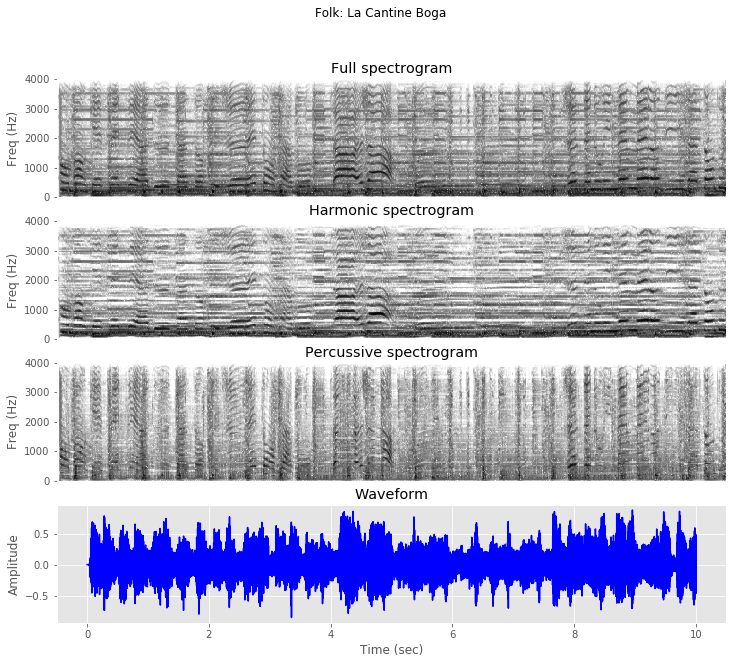

In [28]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

plt.figure(figsize=(12, 10))

plt.suptitle(inf['genre_top'].iloc[0] + ': ' + inf['name'].iloc[0])

plt.subplot(4, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D),ref=rp), 
                         sr=sr, y_axis='linear',cmap='Greys')
plt.ylabel('Freq (Hz)')
# plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(4, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic),ref=rp), 
                         sr=sr, y_axis='linear',cmap='Greys')
plt.ylabel('Freq (Hz)')
# plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(4, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive),ref=rp), 
                         sr=sr, y_axis='linear',cmap='Greys')
# plt.colorbar()
plt.ylabel('Freq (Hz)')
plt.title('Percussive spectrogram')

plt.subplot(4, 1, 4)
time_x = np.array(range(y.shape[0]))/sr
plt.plot(time_x,y, 'b-')
plt.ylabel('Amplitude')
plt.xlabel('Time (sec)')
plt.title('Waveform');



## Reduce noise in spectrograms

Noise components show up in both the harmonic and percussive decomposition components. Setting the margin parameter > 1 during decomposition reduces noise and gives better separation of harmonic and percussive components. 

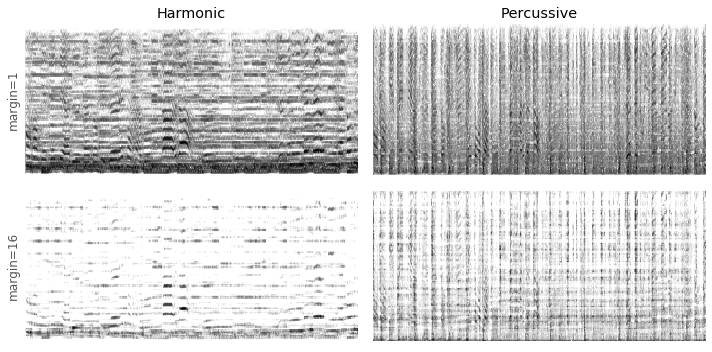

In [29]:
# decomposition using margin = 16
D_harmonic16, D_percussive16 = librosa.decompose.hpss(D, margin=16)

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), 
    sr=sr, y_axis='linear',cmap='Greys')
plt.title('Harmonic')
plt.yticks([])
plt.ylabel('margin=1')

plt.subplot(2, 2, 2)
librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), 
    sr=sr, y_axis='linear',cmap='Greys')
plt.title('Percussive')
plt.yticks([]), plt.ylabel('')

plt.subplot(2, 2, 3)
librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(D_harmonic16), ref=rp), 
    sr=sr, y_axis='linear',cmap='Greys')
plt.yticks([])
plt.ylabel('margin=16')

plt.subplot(2, 2, 4)
librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(D_percussive16), ref=rp), 
    sr=sr, y_axis='linear',cmap='Greys')
plt.yticks([]), plt.ylabel('')

plt.tight_layout()
plt.show()

## Averaged FFTs of original vs decomposed harmonic spectrogram

How does decomposition with a margin filter affect the overall spectra of a spectrogram? 

Comparing the spectra (mean row magnitudes), it's clear that the harmonic component is now more contrasty, which reflects removal of noise components, especially in the lower frequency range. 

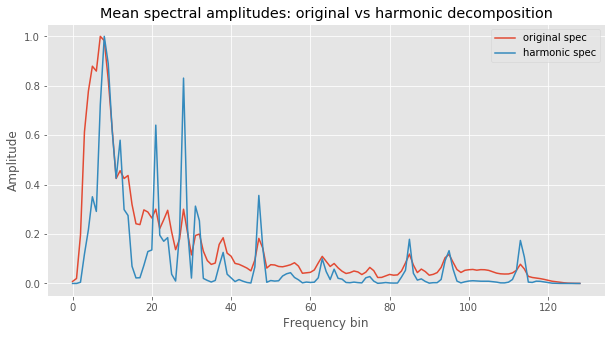

In [30]:
# mean spectrum original
meanfreq = np.mean(np.abs(D), axis=1)
# mean spectrum harmonic
meanfreq_h = np.mean(np.abs(D_harmonic16), axis=1)

plt.figure(figsize=(10,5))
plt.plot(range(len(meanfreq)), meanfreq/max(meanfreq), label='original spec');
plt.plot(range(len(meanfreq_h)), meanfreq_h/max(meanfreq_h), label='harmonic spec');
plt.legend()
plt.ylabel('Amplitude')
plt.xlabel('Frequency bin')
plt.title('Mean spectral amplitudes: original vs harmonic decomposition');


## Averaged spectral magnitudes of original vs decomposed percussive spectrogram

How does decomposition with a margin filter affect the spectral magnitudes at each FFT time point? 

Comparing the energy at each time point (mean column magnitudes) you see the same separation effect: at each time point there is less noise and percussive beats are more noticeable.

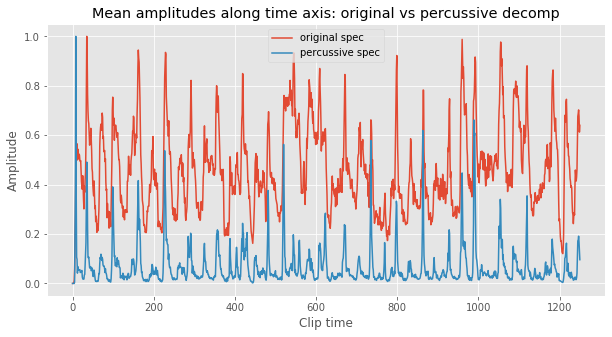

In [31]:
# mean percussive vs original

meantime = np.mean(np.abs(D), axis=0)
meantime_p = np.mean(np.abs(D_percussive16), axis=0)

plt.figure(figsize=(10,5))
plt.plot(range(len(meantime)), meantime/max(meantime), label='original spec');
plt.plot(range(len(meantime_p)), meantime_p/max(meantime_p), label='percussive spec');
plt.legend();
plt.ylabel('Amplitude')
plt.xlabel('Clip time')
plt.title('Mean amplitudes along time axis: original vs percussive decomp');


# Looking at the tempogram

Rather than use the percussive decomposition, I chose to explore librosa's   autocorrelation tempogram, which is considered a robust estimation of tempo in music. The result is an estimation of the tempo components of a recording at successive time steps.

When the tempogram is displayed, tempo components show as streaks. However, there is also a strong near linear increase in overall amplitude at lower frequencies. This trend is visible in all music samples I analyzed regardless of genre, so likely not useful to a classifier. I eliminated that trend by subtracting the mean at each frequency bin.

Refs:
- [librosa Tempo Estimation](https://musicinformationretrieval.com/tempo_estimation.html)

- [Grosche, Peter, Meinard Müller, and Frank Kurth. "Cyclic tempogram - A mid-level tempo representation for music signals." ICASSP, 2010](http://resources.mpi-inf.mpg.de/MIR/tempogramtoolbox/2010_GroscheMuellerKurth_TempogramCyclic_ICASSP.pdf)

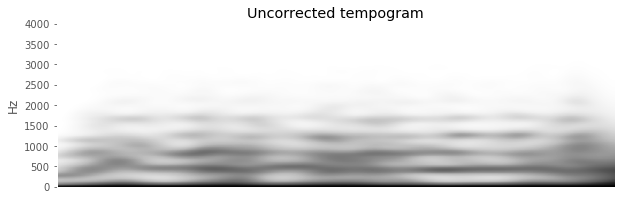

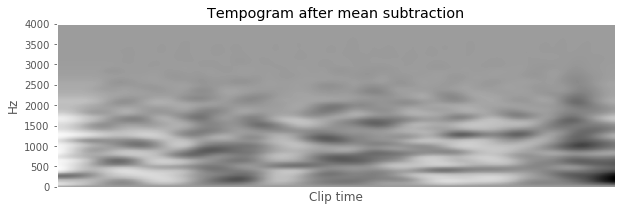

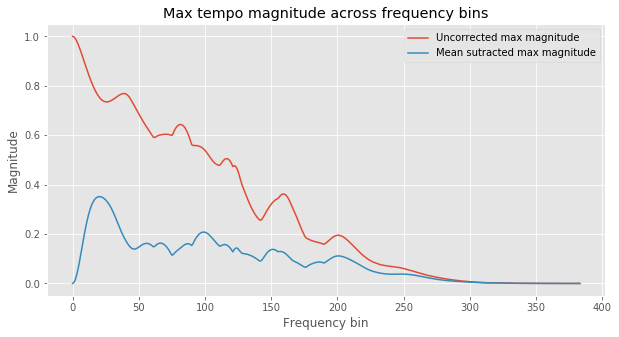

In [32]:
hop_length = 50
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                       hop_length=hop_length)

plt.figure(figsize=(10,3))
tempmag = np.abs(tempogram)
librosa.display.specshow(tempmag, sr=sr, y_axis='linear',cmap='Greys');
plt.title('Uncorrected tempogram');

plt.figure(figsize=(10,3))
t3 = (tempmag.T - np.mean(tempmag, axis=1).T).T
librosa.display.specshow(t3, sr=sr, y_axis='linear',cmap='Greys');
plt.xlabel('Clip time')
plt.title('Tempogram after mean subtraction');

plt.figure(figsize=(10,5))
plt.plot(range(tempogram.shape[0]), np.max(tempogram, axis=1), 
         label='Uncorrected max magnitude')
plt.plot(range(t3.shape[0]), np.max(t3, axis=1), 
         label='Mean sutracted max magnitude');
plt.title('Max tempo magnitude across frequency bins');
plt.ylabel('Magnitude')
plt.xlabel('Frequency bin')
plt.legend();


# Looking at the Mel-frequency cepstrum (MFC)


MFCs are a variation oof a cepstral representation of a time series (a nonlinear "spectrum-of-a-spectrum"). The main difference from a regular cepstrum is that the frequency bins for an MFC are transformed to a mel-frequency representation (scale based on human judged equal frequency distance). 

MFCs are used extensively as features for speech and music analysis and classification, and audio compression, since the frequency scale better fits human perception than a liear FFT derived frequency scale. 

I will use the mean of the MFC frequency amplitudes as a feature vector for my classifier.

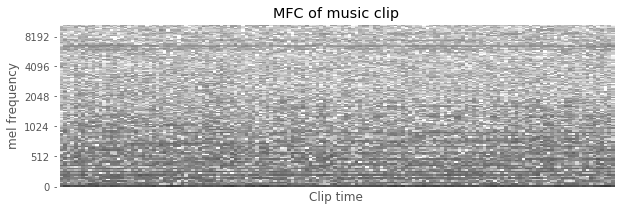

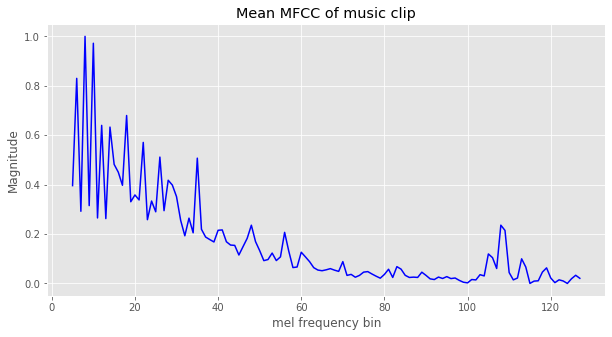

In [33]:
from sklearn.preprocessing import minmax_scale

# MFC calculation params
fftsize=256
nmfcc = 2000
dc_off = 5
windowsize = 5

mfc = np.abs(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=nmfcc, n_fft=fftsize))

plt.figure(figsize=(10,3))
librosa.display.specshow(librosa.amplitude_to_db(mfc), 
                         sr=sr, y_axis='mel',cmap='Greys');
plt.ylabel('mel frequency')
plt.xlabel('Clip time')
plt.title('MFC of music clip');

plt.figure(figsize=(10,5))
mfcmean = np.mean(mfc,axis=1)
plt.ylabel('Magnitude')
plt.xlabel('mel frequency bin')
plt.title('Mean MFCC of music clip');
plt.plot(range(dc_off,len(mfcmean)), minmax_scale(mfcmean[dc_off:]), 'b', label='mean');
